# NEK2 Binding 

- 4 types of RF (default, RF+ class_weight=balanced, Balanced Random Forest Classifier, Balanced Random Forest Classifier + class_weight=balanced
- For each of these 4 types of models, use a different feature set:
- Standardized+SMOTE/UNDER/ADASYN
- Morgan fingerprints radius 2 + SMOTE/UNDER/ADASYN 

In [64]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys
sys.path.append('../')
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def load_data(datapath, type, bindinhib): 
    """
    datapath: (str) directory 
    type: (str)sampling technique 
    """
    trainX = pd.read_csv(datapath+bindinhib+ '_train_x_'+type+'.csv', header=None)
    trainy = pd.read_csv(datapath+bindinhib+ '_train_y_'+type+'.csv',header=None)
    testX = pd.read_csv(datapath+bindinhib+ '_test_x_'+type+'.csv', header=None)
    testy = pd.read_csv(datapath+bindinhib+ '_test_y_'+type+'.csv', header=None)
    return trainX.to_numpy() ,trainy.to_numpy().reshape(-1), testX.to_numpy(), testy.to_numpy().reshape(-1)
    

In [66]:
# I reorganized the directories 
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/bind/'

In [33]:
def fit4RF(trainX, trainy, testX, testy, binding_inhib, RF_title): 
    print('Default RF')
    rfdefault = rf_models(trainX, trainy, testX, testy, 'basic RF', {}, binding_inhib)
    plot_confusion_matrix(trainy, rfdefault['train_pred'], ['0','1'], title=f'{RF_title} Train: Default RF')
    plot_confusion_matrix(testy, rfdefault['test_pred'], ['0','1'], title=f'{RF_title} Test: Default RF')
    
    print('Default RF + BCW')
    rfdefaultBCW = rf_models(trainX, trainy, testX, testy, 'balanced class_weight', {}, binding_inhib)
    plot_confusion_matrix(trainy, rfdefaultBCW['train_pred'], ['0','1'], title=f'{RF_title} Train: Default RF + Bal CW')
    plot_confusion_matrix(testy, rfdefaultBCW ['test_pred'], ['0','1'], title=f'{RF_title} Test: Default RF + Bal CW')

    print('Balanced RF')
    brfc = rf_models(trainX, trainy, testX, testy, 'BalancedRandomForestClassifier', {}, binding_inhib)
    plot_confusion_matrix(trainy, brfc['train_pred'], ['0','1'], title=f'{RF_title} Train: Balanced RF')
    plot_confusion_matrix(testy, brfc['test_pred'], ['0','1'], title=f'{RF_title} Test: Balanced RF')

    print('Balanced RF + BCW')
    brfcBCW = rf_models(trainX, trainy, testX, testy, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, binding_inhib)
    plot_confusion_matrix(trainy, brfcBCW['train_pred'], ['0','1'], title=f'{RF_title} Train: Balanced RF + Bal CW')
    plot_confusion_matrix(testy,brfcBCW['test_pred'], ['0','1'], title=f'{RF_title} Test: Balanced RF + Bal CW')

    return rfdefault, rfdefaultBCW, brfc, brfcBCW

# Datasets: 

All for trainX, trainy, testx, testY splits (all based off fold1 as the test set) 

- datasets that are bind/inhib_test_x_ADASYN.csv or train_y_SMOTE.csv are just the normalized data + whichever sampling technique for train, test
- norm/normalized is using RD `MolStandardize` based on the molecules generated by rdkit smiles strings
- norm/normalized + SMOTE/UNDER/ADASYN
- normMorgan2 or Morgan2combo + SMOTE/UNDER/ADASYN is the standardized/normalized feats combined datasets 

# Basic RF with standardized MOE feats

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.901, precision: 0.100, recall: 0.167, sensitivity: 0.167, specificity: 0.934
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.943, precision: 0.167, recall: 0.083, sensitivity: 0.083, specificity: 0.982
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.908, precision: 0.111, recall: 0.167, sensitivity: 0.167, specificity: 0.941
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.143, recall: 0.083, sensitivity: 0.083, specificity: 0.978


<Figure size 600x400 with 0 Axes>

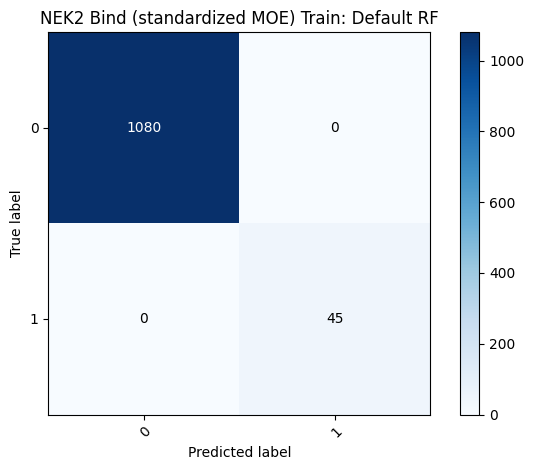

<Figure size 600x400 with 0 Axes>

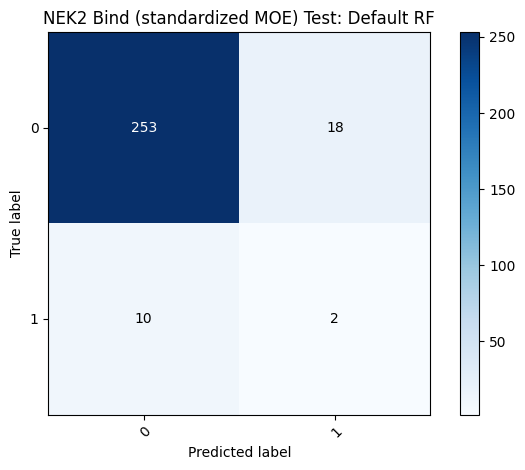

<Figure size 600x400 with 0 Axes>

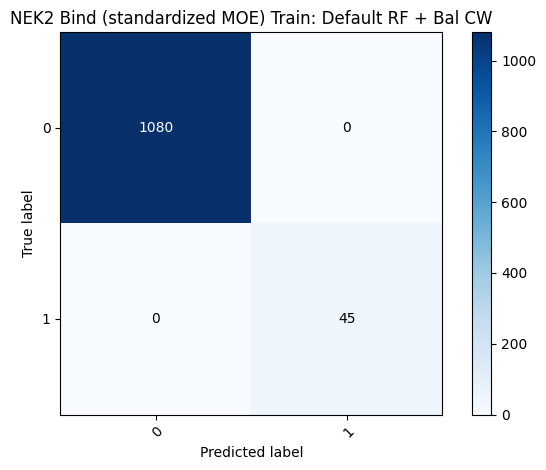

<Figure size 600x400 with 0 Axes>

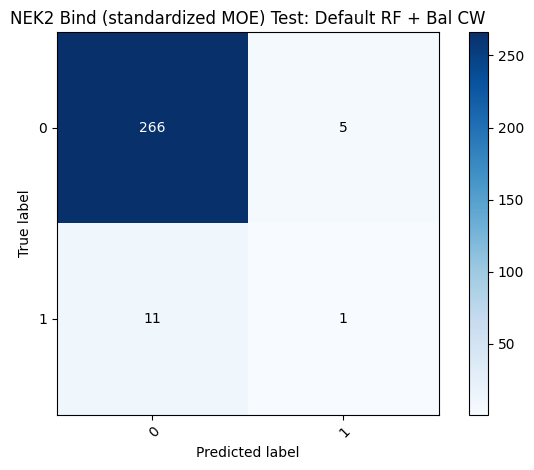

<Figure size 600x400 with 0 Axes>

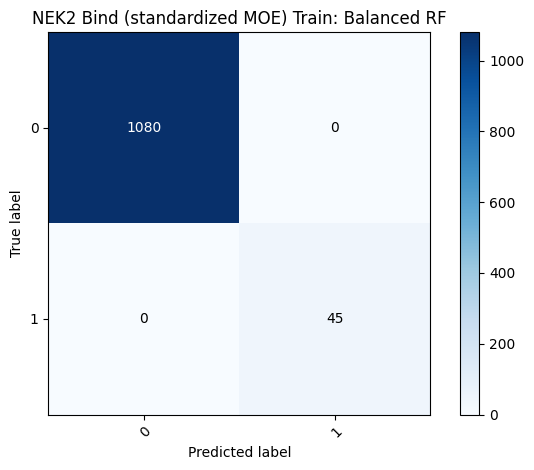

<Figure size 600x400 with 0 Axes>

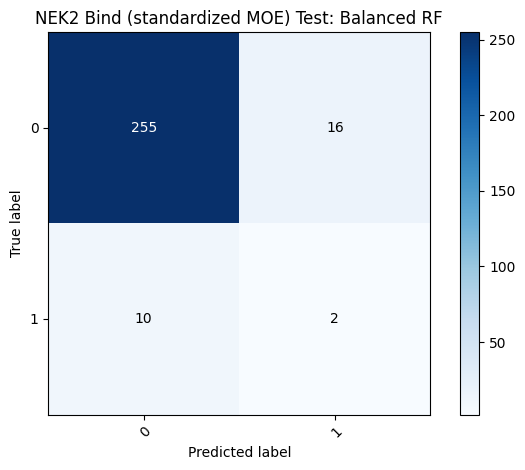

<Figure size 600x400 with 0 Axes>

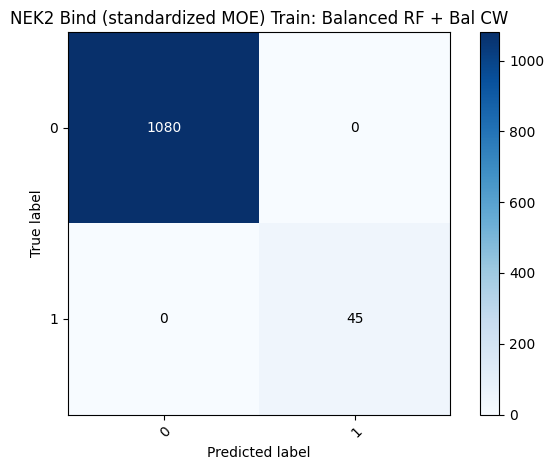

<Figure size 600x400 with 0 Axes>

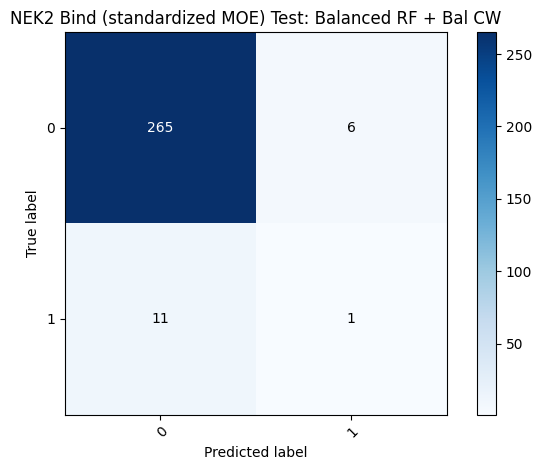

In [34]:
norm_type = 'normalized'

trainX, trainy, testX, testy = load_data(split_path, norm_type, 'bind')
trainX.shape, trainy.shape, testX.shape, testy.shape
defaultnorm, balCWnorm, brfcnorm,brfcBCWnorm = fit4RF(trainX, trainy, testX, testy, 'binding', 'NEK2 Bind (standardized MOE)')

In [63]:
trainX.shape, trainy.shape, testX.shape, testy.shape

((1125, 306), (1125,), (283, 306), (283,))

# MOE feats with SMOTE 

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.919, precision: 0.211, recall: 0.333, sensitivity: 0.333, specificity: 0.945
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.919, precision: 0.211, recall: 0.333, sensitivity: 0.333, specificity: 0.945
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.915, precision: 0.200, recall: 0.333, sensitivity: 0.333, specificity: 0.941
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.919, precision: 0.211, recall: 0.333, sensitivity: 0.333, specificity: 0.945


<Figure size 600x400 with 0 Axes>

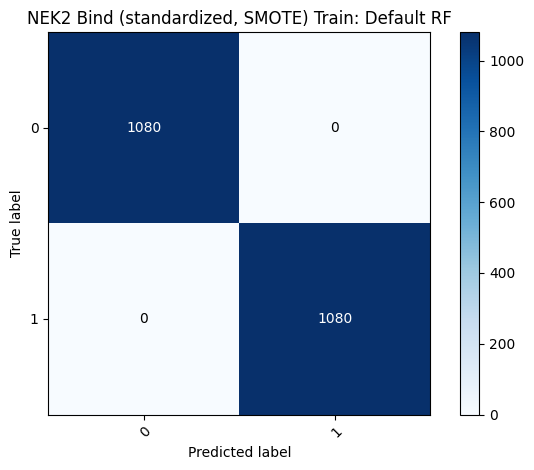

<Figure size 600x400 with 0 Axes>

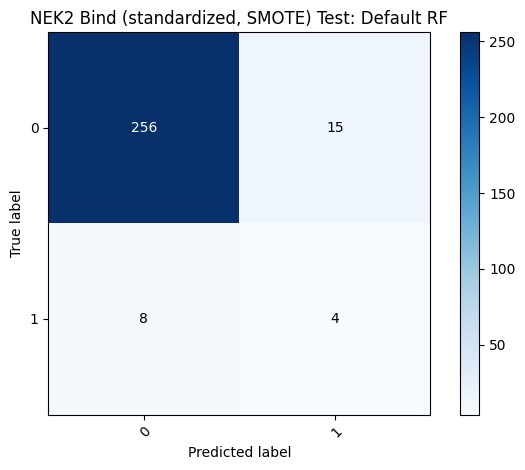

<Figure size 600x400 with 0 Axes>

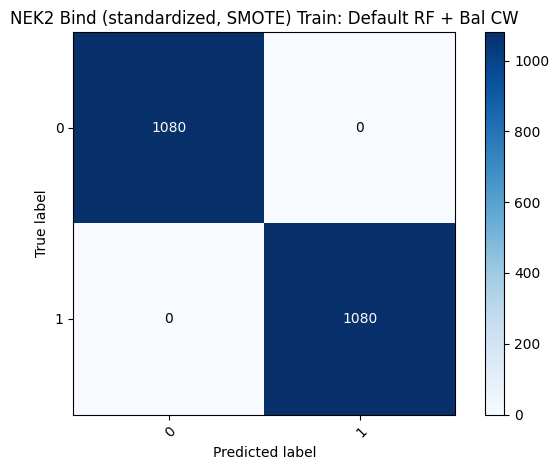

<Figure size 600x400 with 0 Axes>

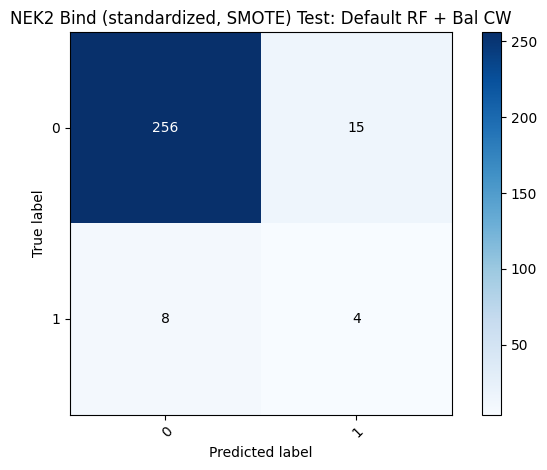

<Figure size 600x400 with 0 Axes>

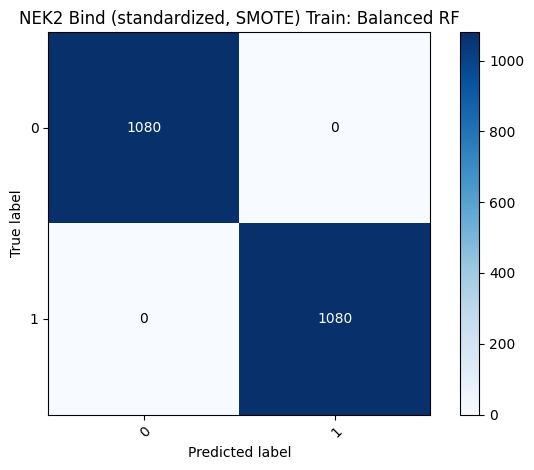

<Figure size 600x400 with 0 Axes>

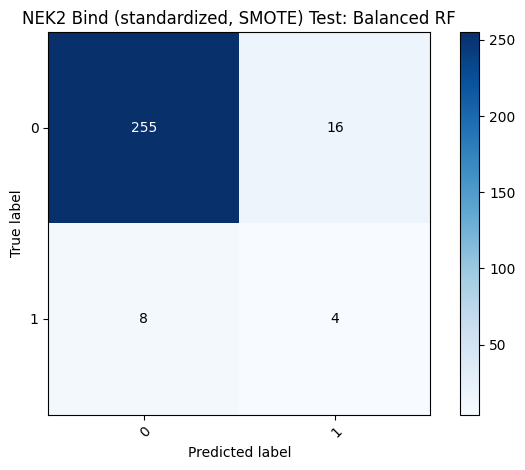

<Figure size 600x400 with 0 Axes>

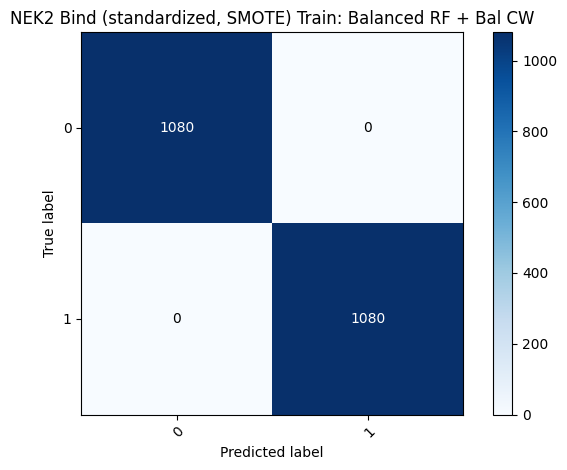

<Figure size 600x400 with 0 Axes>

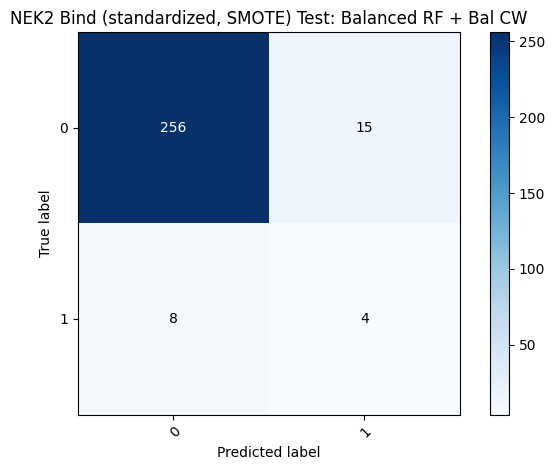

In [43]:
normSMOTE  = 'normSMOTE'
trainXSMOTE, trainySMOTE, testXSMOTE, testySMOTE = load_data(split_path, normSMOTE, 'bind')
trainXSMOTE.shape, trainySMOTE.shape, testXSMOTE.shape, testySMOTE.shape
defaultnormSMOTE, balCWnormSMOTE, brfcnormSMOTE,brfcBCWnormSMOTE = fit4RF(trainXSMOTE, trainySMOTE, 
                                                                          testXSMOTE, testySMOTE, 'binding', 'NEK2 Bind (standardized, SMOTE)')

# MOE feats with UNDER (undersampler from imbalanced learn)

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.118, recall: 0.167, sensitivity: 0.167, specificity: 0.945
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.943, precision: 0.167, recall: 0.083, sensitivity: 0.083, specificity: 0.982
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.901, precision: 0.100, recall: 0.167, sensitivity: 0.167, specificity: 0.934
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.143, recall: 0.083, sensitivity: 0.083, specificity: 0.978


<Figure size 600x400 with 0 Axes>

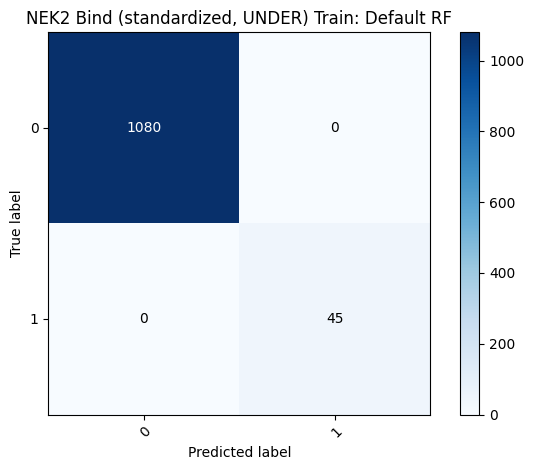

<Figure size 600x400 with 0 Axes>

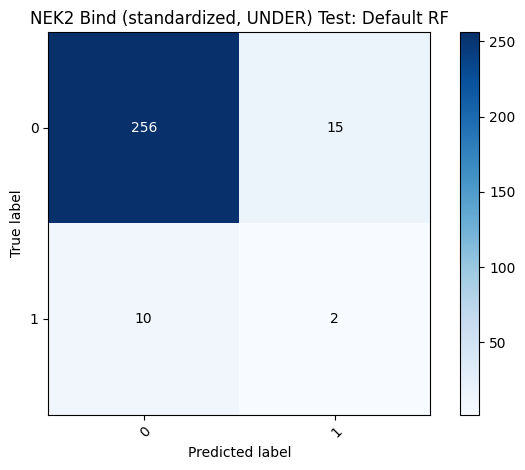

<Figure size 600x400 with 0 Axes>

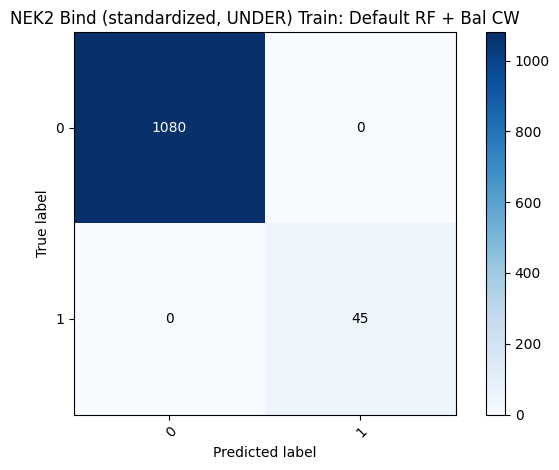

<Figure size 600x400 with 0 Axes>

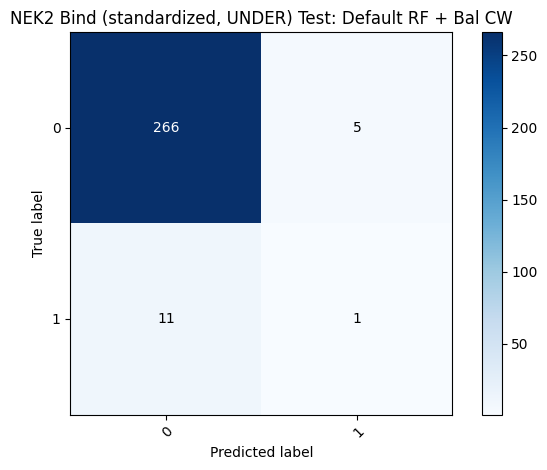

<Figure size 600x400 with 0 Axes>

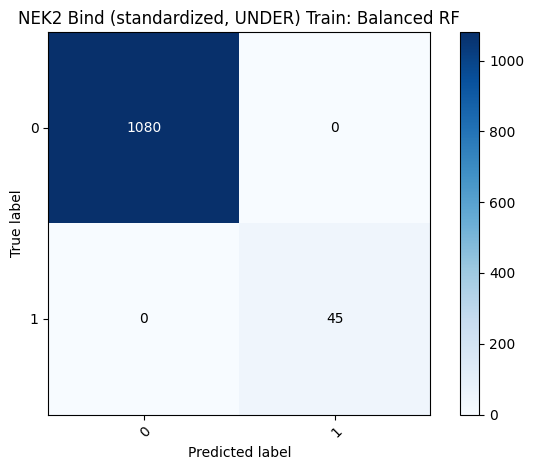

<Figure size 600x400 with 0 Axes>

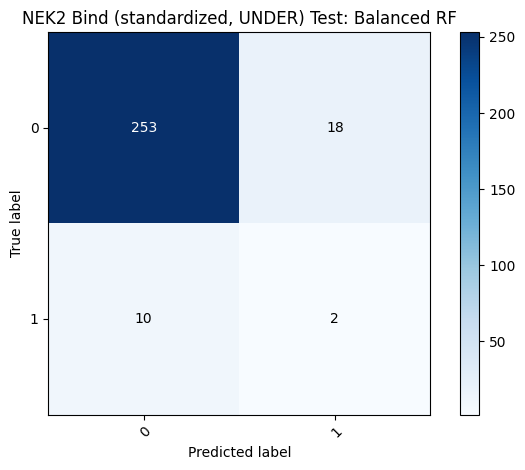

<Figure size 600x400 with 0 Axes>

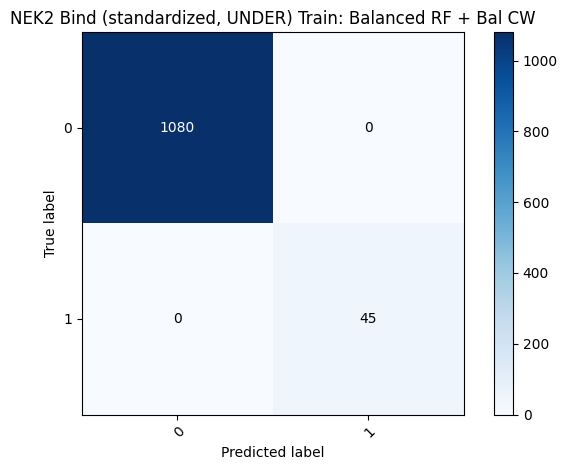

<Figure size 600x400 with 0 Axes>

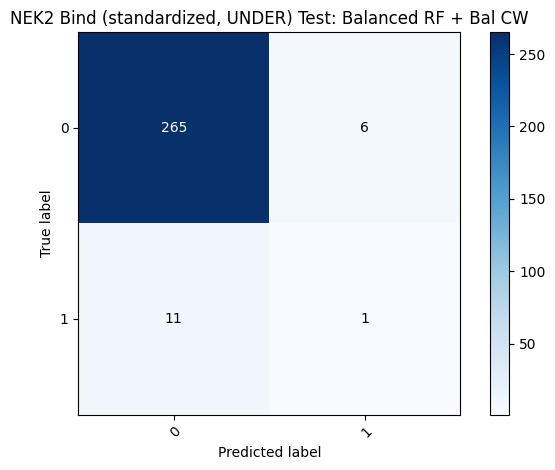

In [38]:
normUNDER  = 'normUNDER'
trainXUNDER, trainyUNDER, testXUNDER, testyUNDER = load_data(split_path, normUNDER, 'bind')
trainXUNDER.shape, trainyUNDER.shape, testXUNDER.shape, testyUNDER.shape
defaultnormUNDER, balCWnormUNDER, brfcnormUNDER,brfcBCWnormUNDER = fit4RF(trainXUNDER, trainyUNDER, 
                                                                          testXUNDER, testyUNDER, 'binding', 'NEK2 Bind (standardized, UNDER)')

# MOE feats with ADASYN

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.286, recall: 0.333, sensitivity: 0.333, specificity: 0.963
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.286, recall: 0.333, sensitivity: 0.333, specificity: 0.963
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.286, recall: 0.333, sensitivity: 0.333, specificity: 0.963
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.933, precision: 0.267, recall: 0.333, sensitivity: 0.333, specificity: 0.959


<Figure size 600x400 with 0 Axes>

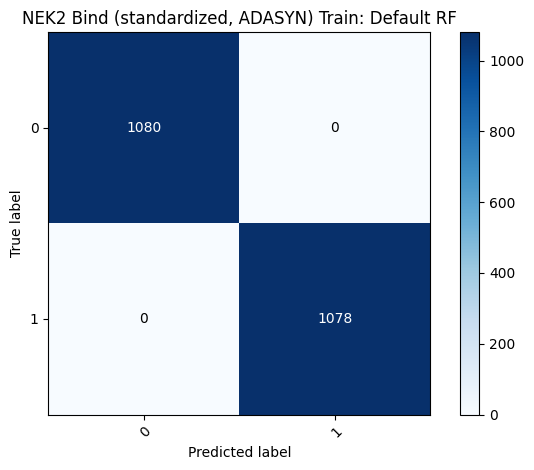

<Figure size 600x400 with 0 Axes>

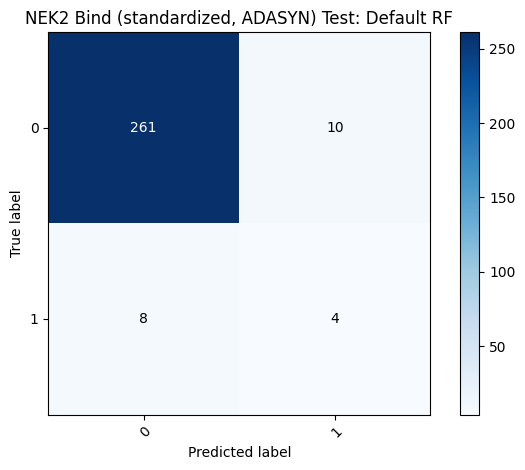

<Figure size 600x400 with 0 Axes>

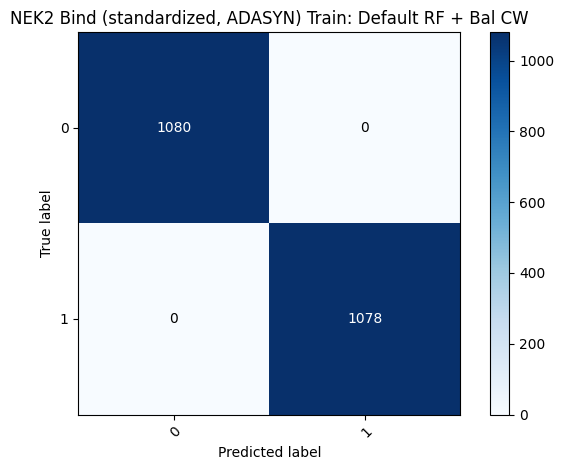

<Figure size 600x400 with 0 Axes>

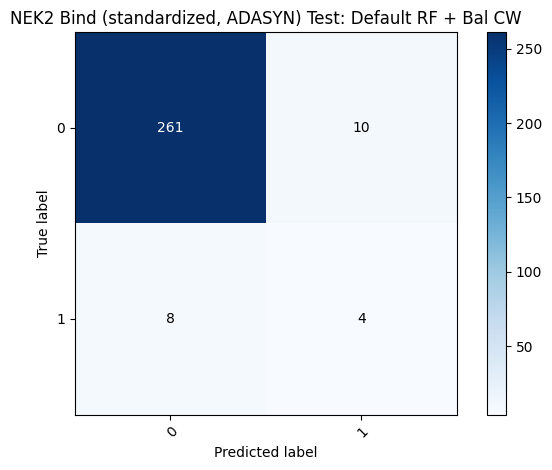

<Figure size 600x400 with 0 Axes>

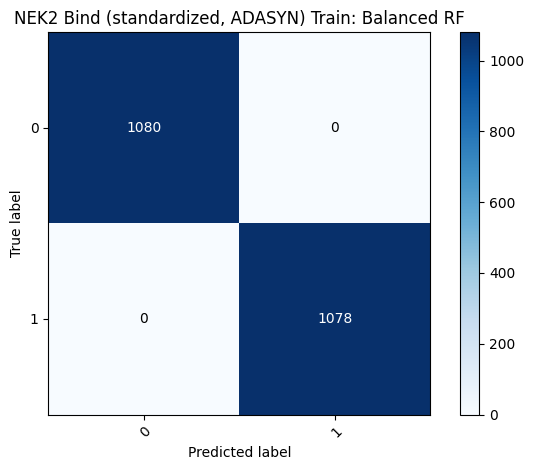

<Figure size 600x400 with 0 Axes>

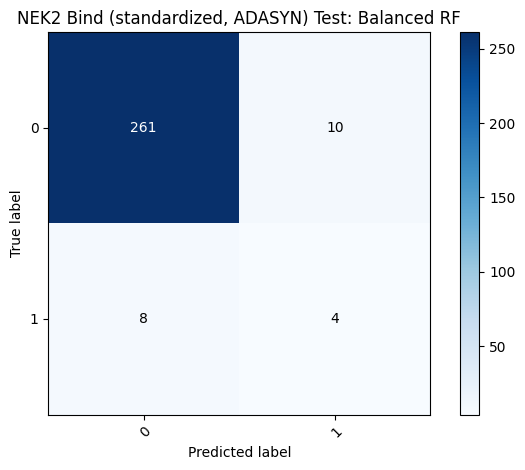

<Figure size 600x400 with 0 Axes>

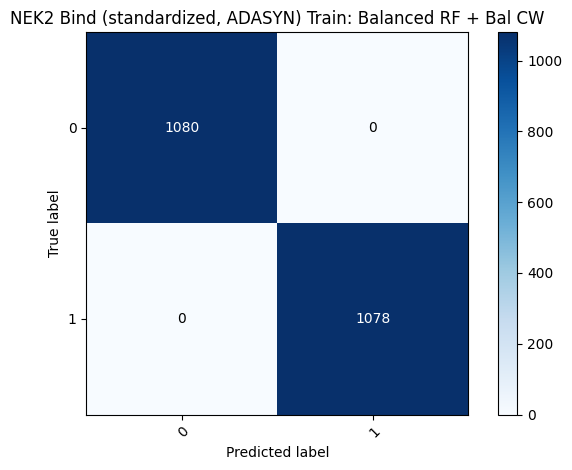

<Figure size 600x400 with 0 Axes>

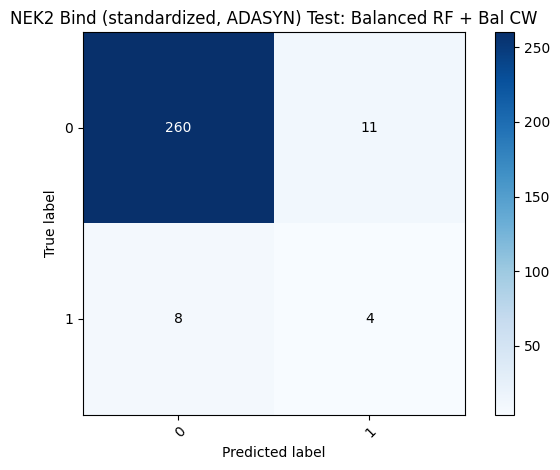

In [44]:
normADASYN  = 'normADASYN'
trainXADASYN, trainyADASYN, testXADASYN, testyADASYN = load_data(split_path, normADASYN, 'bind')
trainXADASYN.shape, trainyADASYN.shape, testXADASYN.shape, testyADASYN.shape
defaultnormADASYN, balCWnormADASYN, brfcnormADASYN,brfcBCWnormADASYN = fit4RF(trainXADASYN, trainyADASYN, 
                                                                    testXADASYN, testyADASYN, 'binding', 'NEK2 Bind (standardized, ADASYN)')

# Morgan Fingerprints 

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.908, precision: 0.111, recall: 0.167, sensitivity: 0.167, specificity: 0.941
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.143, recall: 0.083, sensitivity: 0.083, specificity: 0.978
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.901, precision: 0.100, recall: 0.167, sensitivity: 0.167, specificity: 0.934
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.143, recall: 0.083, sensitivity: 0.083, specificity: 0.978


<Figure size 600x400 with 0 Axes>

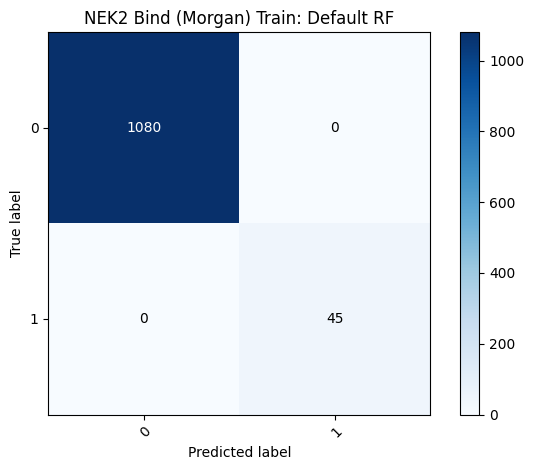

<Figure size 600x400 with 0 Axes>

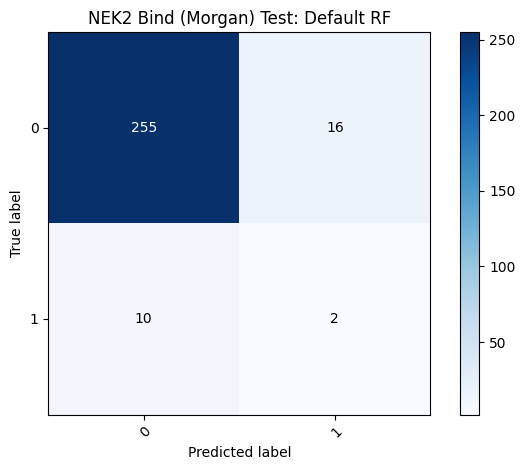

<Figure size 600x400 with 0 Axes>

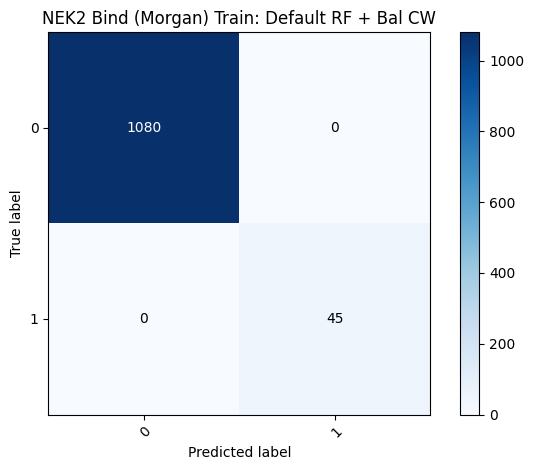

<Figure size 600x400 with 0 Axes>

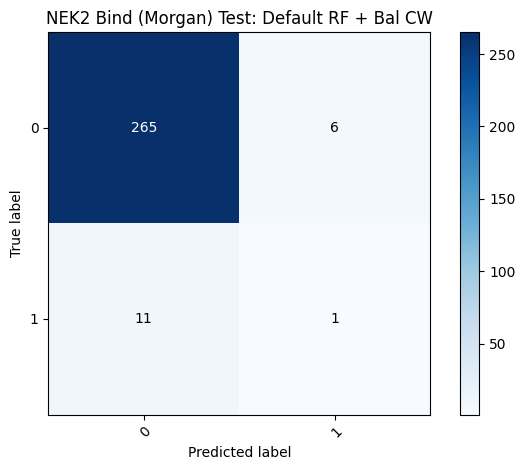

<Figure size 600x400 with 0 Axes>

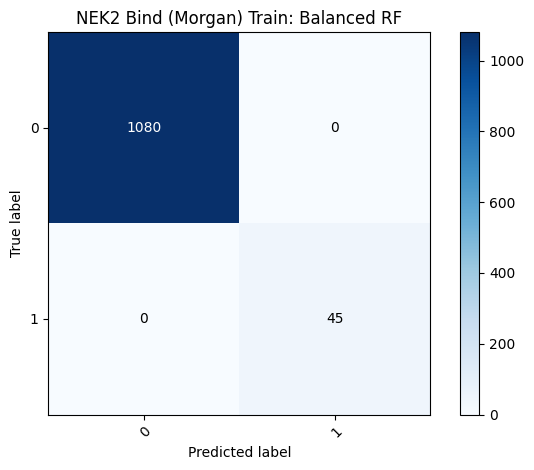

<Figure size 600x400 with 0 Axes>

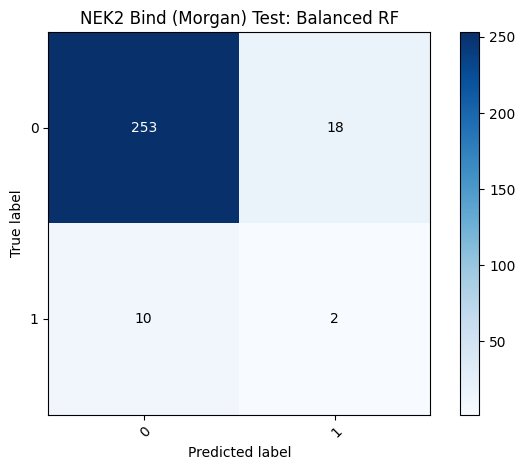

<Figure size 600x400 with 0 Axes>

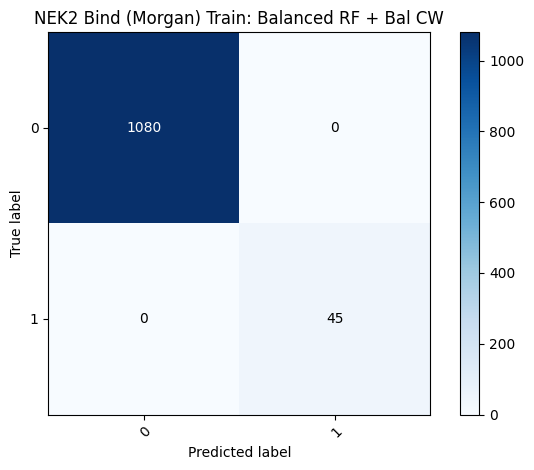

<Figure size 600x400 with 0 Axes>

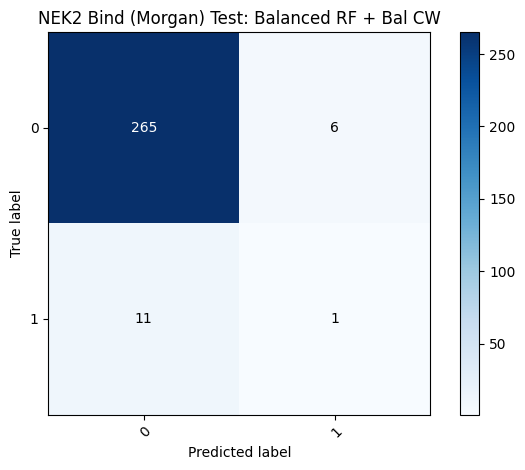

In [42]:
just_Morgan = 'normMorgan2'

trainX_Morgan, trainy_Morgan, testX_Morgan, testy_Morgan = load_data(split_path, just_Morgan, 'bind')
trainX_Morgan.shape, trainy_Morgan.shape, testX_Morgan.shape, testy_Morgan.shape
defaultnorm_Morgan, balCWnorm_Morgan, brfcnorm_Morgan,brfcBCWnorm_Morgan = fit4RF(trainX_Morgan, trainy_Morgan,
                                                                            testX_Morgan, testy_Morgan, 'binding', 'NEK2 Bind (Morgan)')

# Morgan + SMOTE 

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.250, recall: 0.250, sensitivity: 0.250, specificity: 0.967
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.273, recall: 0.250, sensitivity: 0.250, specificity: 0.970
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.933, precision: 0.231, recall: 0.250, sensitivity: 0.250, specificity: 0.963
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.286, recall: 0.333, sensitivity: 0.333, specificity: 0.963


<Figure size 600x400 with 0 Axes>

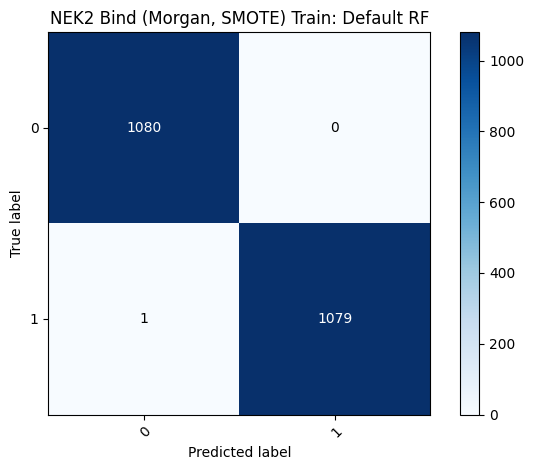

<Figure size 600x400 with 0 Axes>

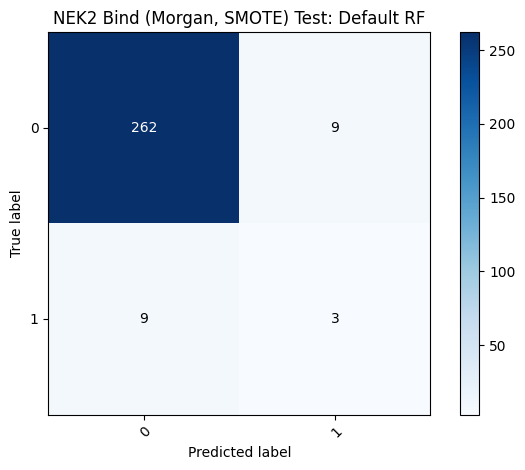

<Figure size 600x400 with 0 Axes>

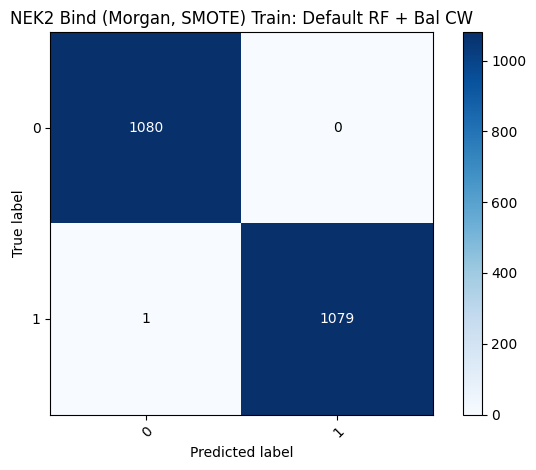

<Figure size 600x400 with 0 Axes>

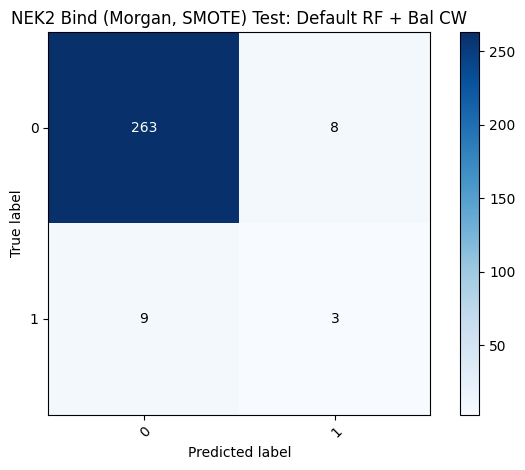

<Figure size 600x400 with 0 Axes>

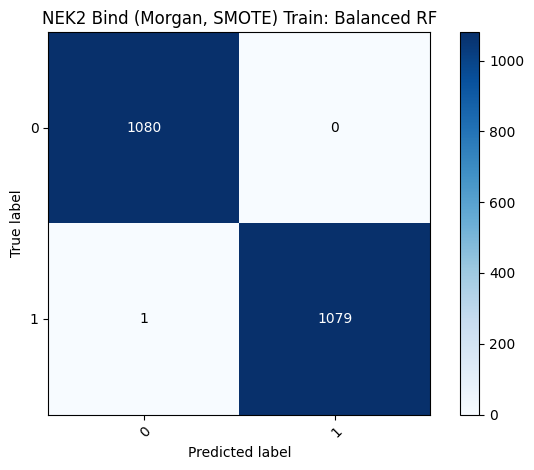

<Figure size 600x400 with 0 Axes>

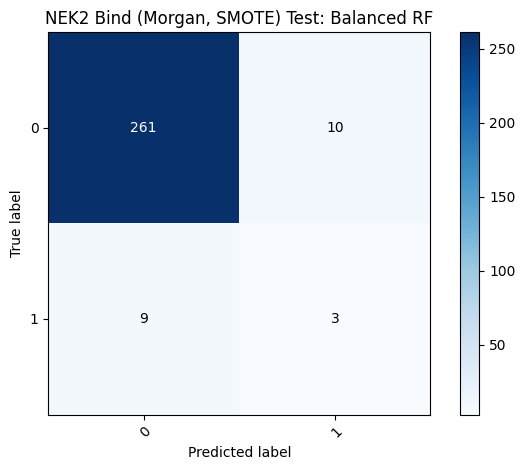

<Figure size 600x400 with 0 Axes>

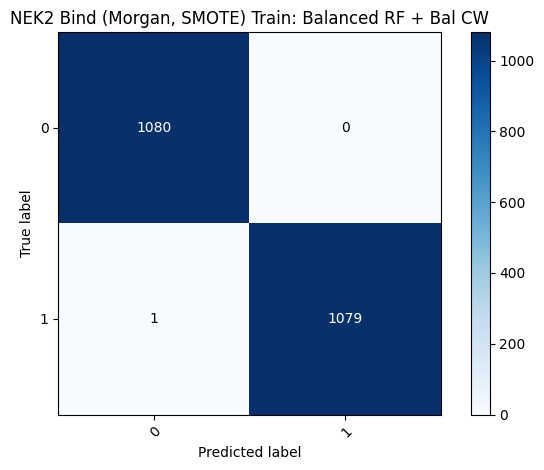

<Figure size 600x400 with 0 Axes>

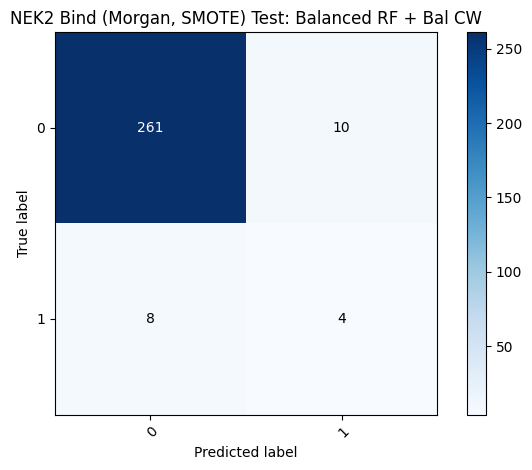

In [49]:
Mor_SMOTE = 'Morgan2SMOTE'

trainX_Mor_SMOTE, trainy_Mor_SMOTE, testX_Mor_SMOTE, testy_Mor_SMOTE = load_data(split_path, Mor_SMOTE, 'bind')
trainX_Mor_SMOTE.shape, trainy_Mor_SMOTE.shape, testX_Mor_SMOTE.shape, testy_Mor_SMOTE.shape
defaultnorm_Mor_SMOTE, balCWnorm_Mor_SMOTE, brfcnorm_Mor_SMOTE,brfcBCWnorm_Mor_SMOTE = fit4RF(trainX_Mor_SMOTE, trainy_Mor_SMOTE,
                                                                            testX_Mor_SMOTE, testy_Mor_SMOTE, 'binding', 'NEK2 Bind (Morgan, SMOTE)')

# Morgan + UNDER

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.647, precision: 0.085, recall: 0.750, sensitivity: 0.750, specificity: 0.642
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.654, precision: 0.087, recall: 0.750, sensitivity: 0.750, specificity: 0.649
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.682, precision: 0.094, recall: 0.750, sensitivity: 0.750, specificity: 0.679
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.661, precision: 0.088, recall: 0.750, sensitivity: 0.750, specificity: 0.657


<Figure size 600x400 with 0 Axes>

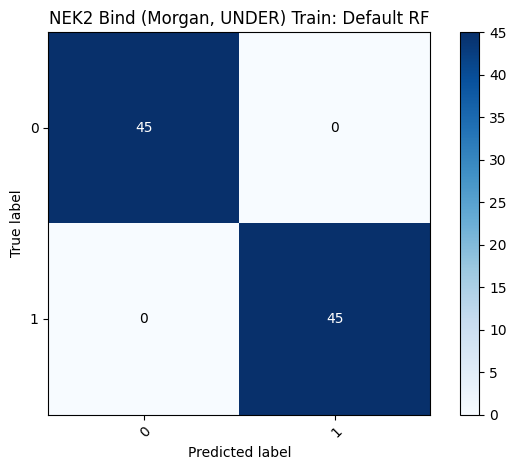

<Figure size 600x400 with 0 Axes>

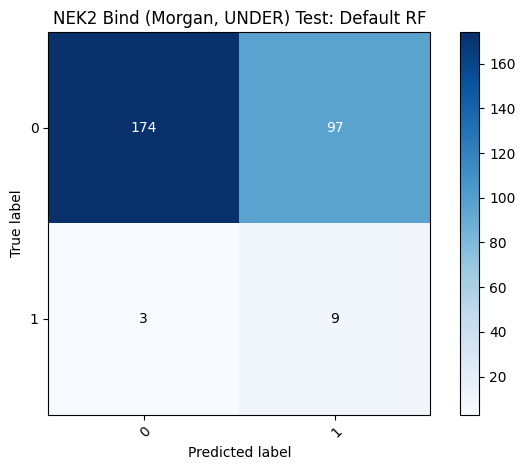

<Figure size 600x400 with 0 Axes>

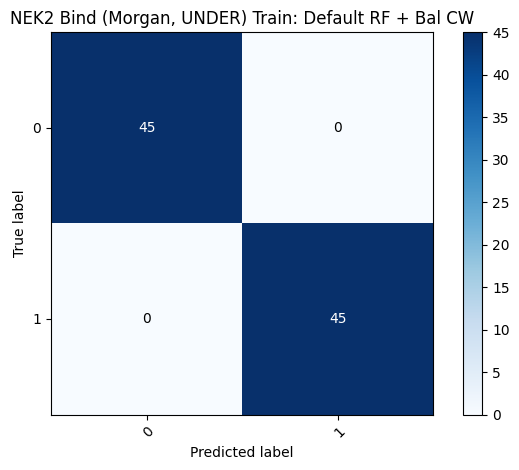

<Figure size 600x400 with 0 Axes>

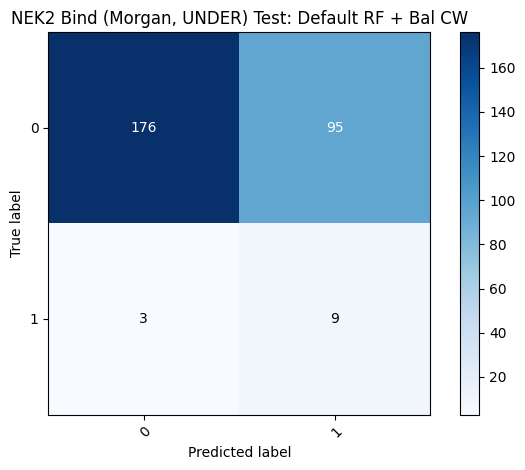

<Figure size 600x400 with 0 Axes>

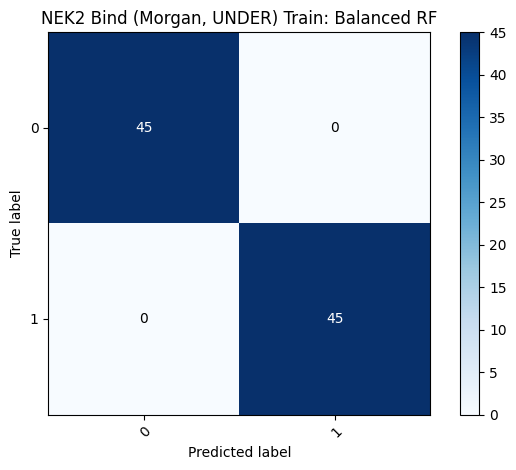

<Figure size 600x400 with 0 Axes>

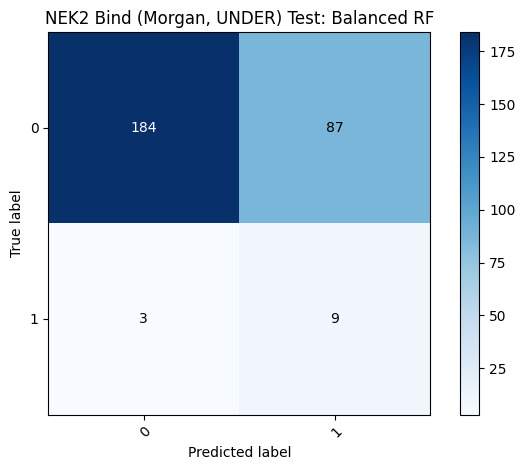

<Figure size 600x400 with 0 Axes>

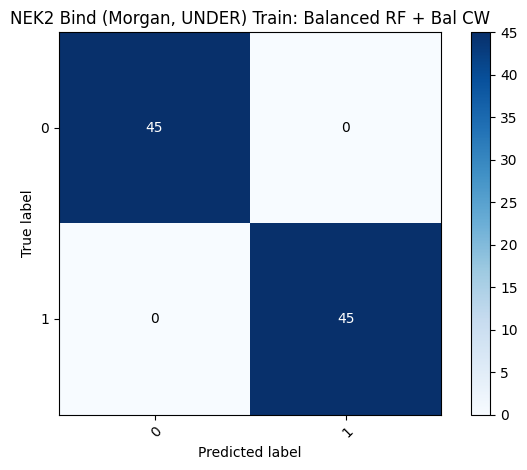

<Figure size 600x400 with 0 Axes>

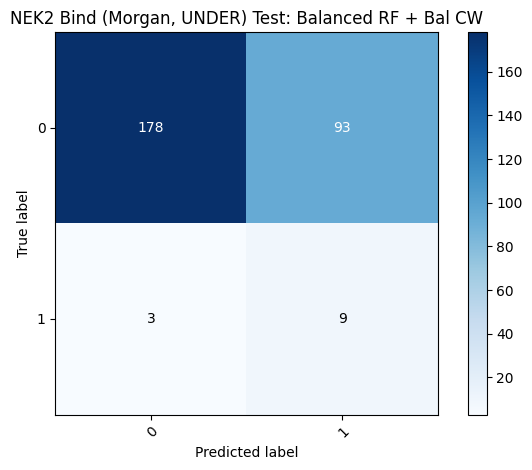

In [50]:
Mor_UNDER = 'Morgan2UNDER'

trainX_Mor_UNDER, trainy_Mor_UNDER, testX_Mor_UNDER, testy_Mor_UNDER = load_data(split_path, Mor_UNDER, 'bind')
trainX_Mor_UNDER.shape, trainy_Mor_UNDER.shape, testX_Mor_UNDER.shape, testy_Mor_UNDER.shape
defaultnorm_Morgan, balCWnorm_Morgan, brfcnorm_Morgan,brfcBCWnorm_Morgan = fit4RF(trainX_Mor_UNDER, trainy_Mor_UNDER,
                                                                            testX_Mor_UNDER, testy_Mor_UNDER, 'binding', 'NEK2 Bind (Morgan, UNDER)')

In [62]:
178+93+3+9

283

# Morgan + ADASYN

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.961, precision: 0.556, recall: 0.417, sensitivity: 0.417, specificity: 0.985
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.954, precision: 0.455, recall: 0.417, sensitivity: 0.417, specificity: 0.978
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.961, precision: 0.556, recall: 0.417, sensitivity: 0.417, specificity: 0.985
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, sensitivity: 0.999, specificity: 1.000
TEST: accuracy: 0.954, precision: 0.455, recall: 0.417, sensitivity: 0.417, specificity: 0.978


<Figure size 600x400 with 0 Axes>

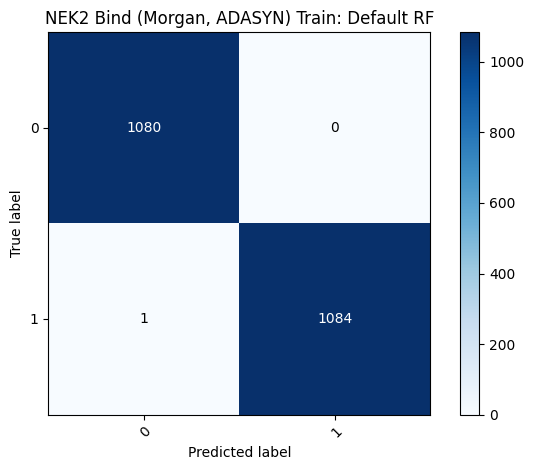

<Figure size 600x400 with 0 Axes>

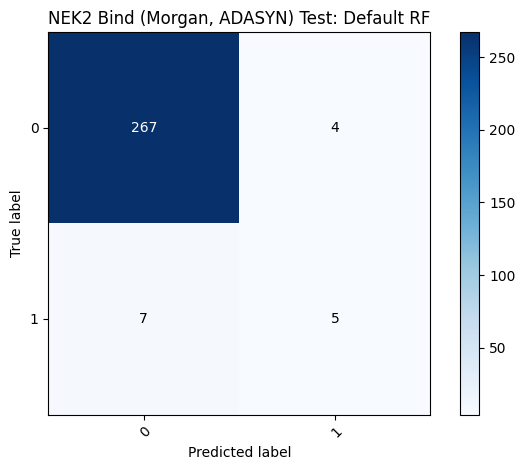

<Figure size 600x400 with 0 Axes>

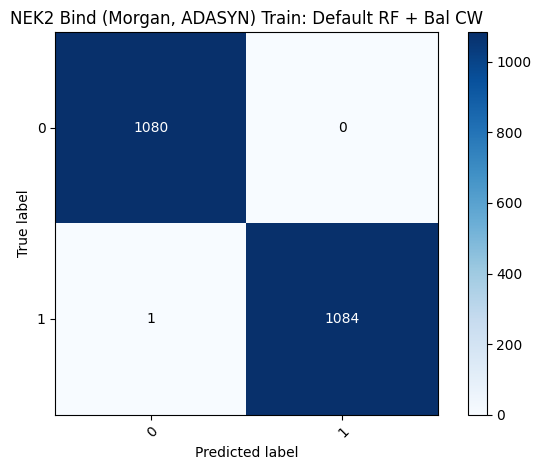

<Figure size 600x400 with 0 Axes>

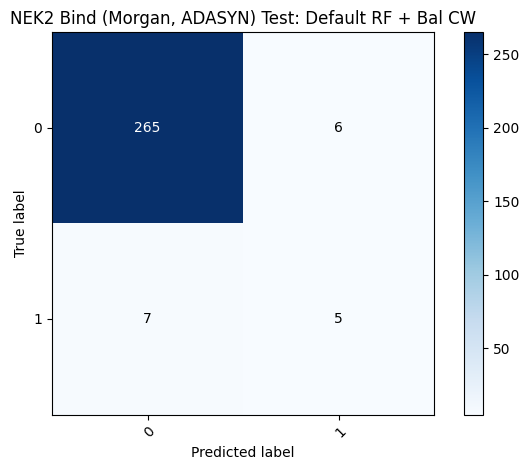

<Figure size 600x400 with 0 Axes>

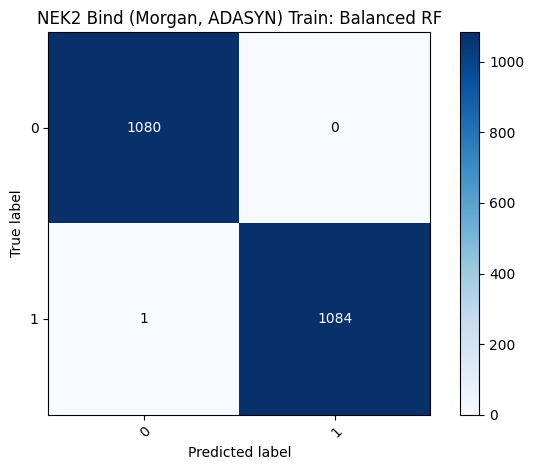

<Figure size 600x400 with 0 Axes>

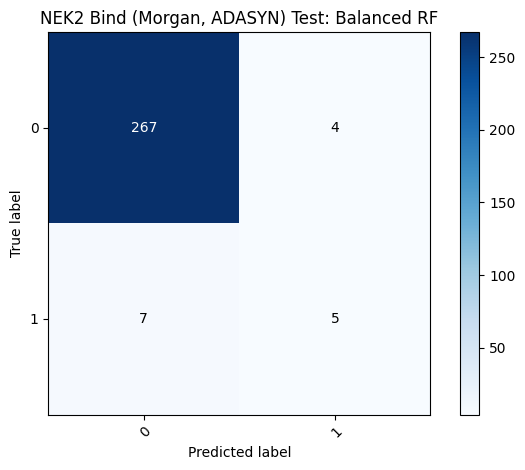

<Figure size 600x400 with 0 Axes>

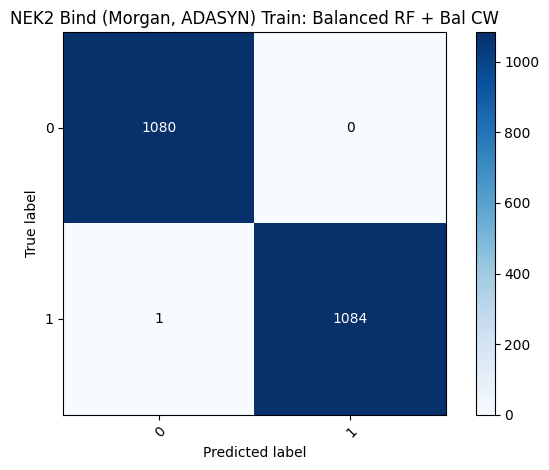

<Figure size 600x400 with 0 Axes>

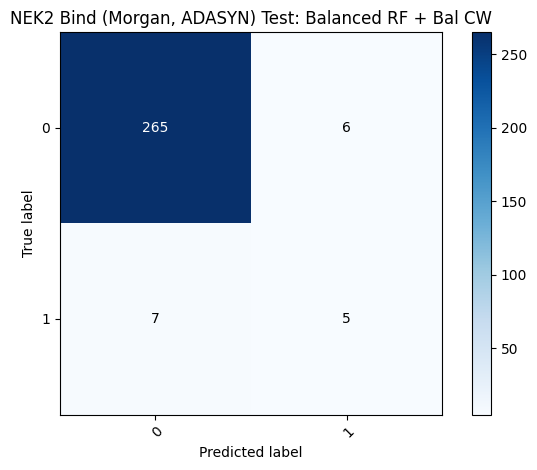

In [51]:
Mor_ADASYN = 'Morgan2ADASYN'

trainX_Mor_ADASYN, trainy_Mor_ADASYN, testX_Mor_ADASYN, testy_Mor_ADASYN = load_data(split_path, Mor_ADASYN, 'bind')
trainX_Mor_ADASYN.shape, trainy_Mor_ADASYN.shape, testX_Mor_ADASYN.shape, testy_Mor_ADASYN.shape
defaultnorm_ADASYN, balCWnorm_ADASYN, brfcnorm_ADASYN,brfcBCWnorm_ADASYN = fit4RF(trainX_Mor_ADASYN, trainy_Mor_ADASYN,
                                                                            testX_Mor_ADASYN, testy_Mor_ADASYN, 'binding', 'NEK2 Bind (Morgan, ADASYN)')

# Combined MOE + Morgan

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.200, recall: 0.167, sensitivity: 0.167, specificity: 0.970
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.943, precision: 0.250, recall: 0.167, sensitivity: 0.167, specificity: 0.978
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.222, recall: 0.167, sensitivity: 0.167, specificity: 0.974
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.943, precision: 0.250, recall: 0.167, sensitivity: 0.167, specificity: 0.978


<Figure size 600x400 with 0 Axes>

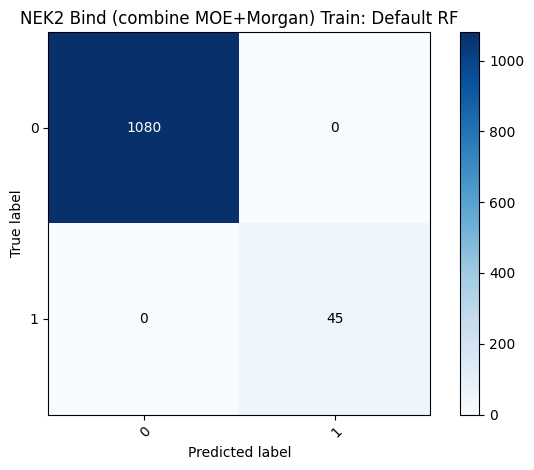

<Figure size 600x400 with 0 Axes>

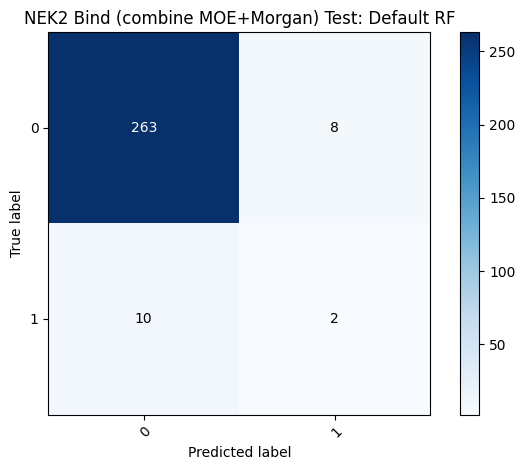

<Figure size 600x400 with 0 Axes>

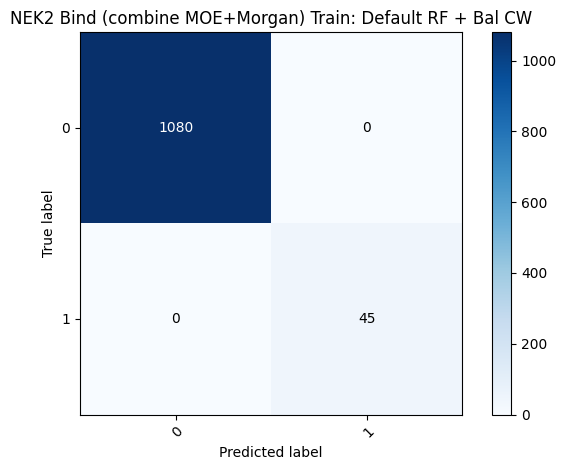

<Figure size 600x400 with 0 Axes>

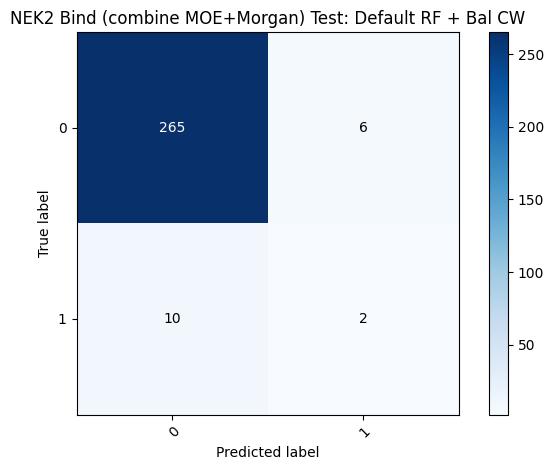

<Figure size 600x400 with 0 Axes>

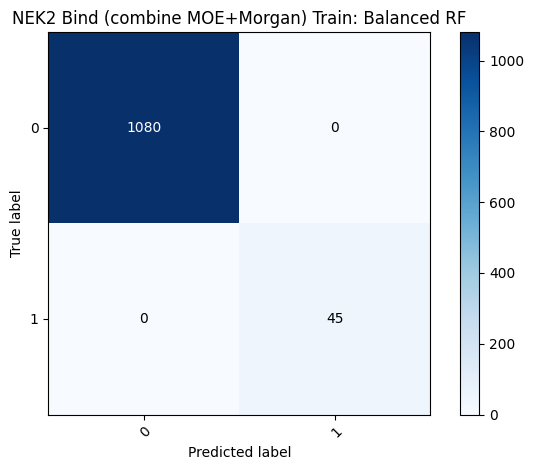

<Figure size 600x400 with 0 Axes>

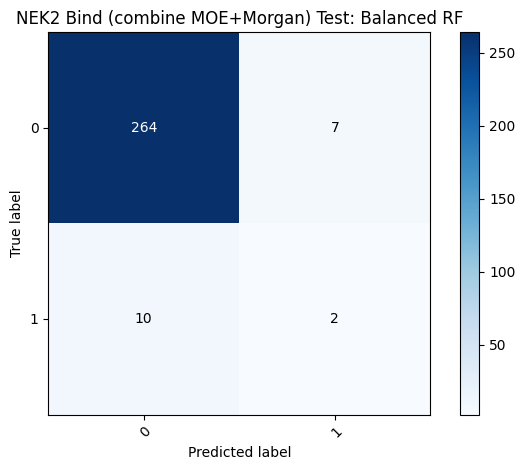

<Figure size 600x400 with 0 Axes>

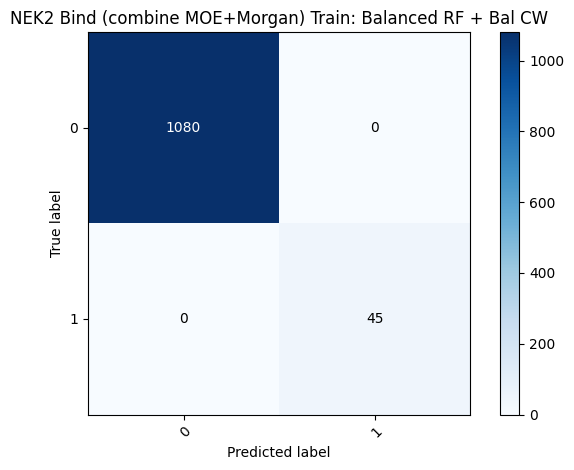

<Figure size 600x400 with 0 Axes>

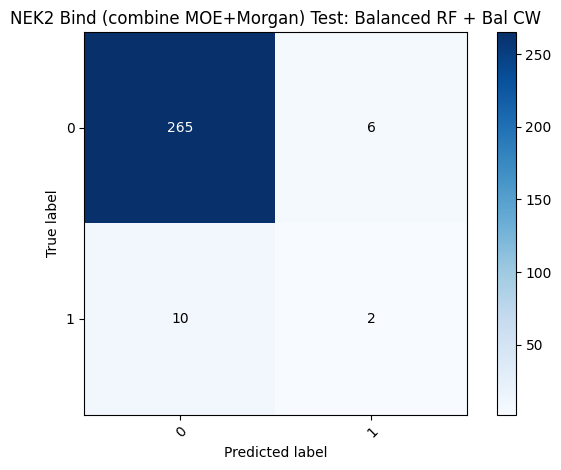

In [53]:
combo01 = 'MOEMorgan2combo'

trainX_MorMOE, trainy_MorMOE, testX_MorMOE, testy_MorMOE = load_data(split_path, combo01, 'bind')
trainX_MorMOE.shape, trainy_MorMOE.shape, testX_MorMOE.shape, testy_MorMOE.shape
defaultMorMOE, balCWMorMOE, brfcMorMOE,brfcBCWMorMOE = fit4RF(trainX_MorMOE, trainy_MorMOE,
                                                                            testX_MorMOE, testy_MorMOE, 'binding', 'NEK2 Bind (combine MOE+Morgan)')

# Combined MOE + Morgan, SMOTE

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.951, precision: 0.400, recall: 0.333, sensitivity: 0.333, specificity: 0.978
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.951, precision: 0.400, recall: 0.333, sensitivity: 0.333, specificity: 0.978
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.947, precision: 0.364, recall: 0.333, sensitivity: 0.333, specificity: 0.974
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.943, precision: 0.333, recall: 0.333, sensitivity: 0.333, specificity: 0.970


<Figure size 600x400 with 0 Axes>

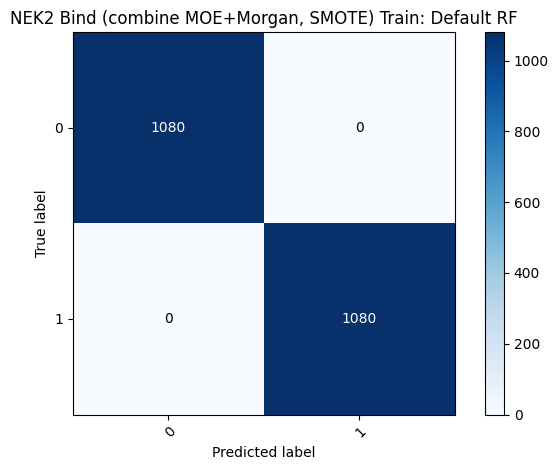

<Figure size 600x400 with 0 Axes>

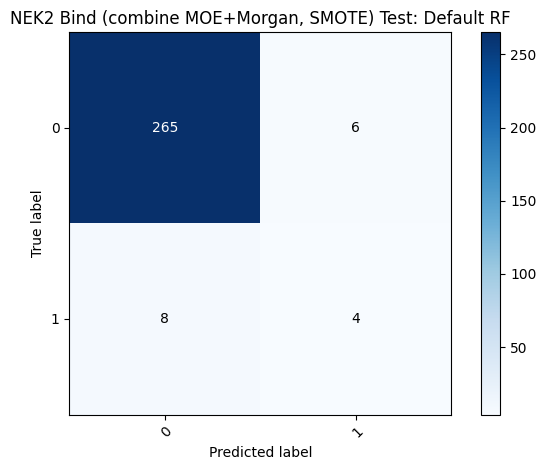

<Figure size 600x400 with 0 Axes>

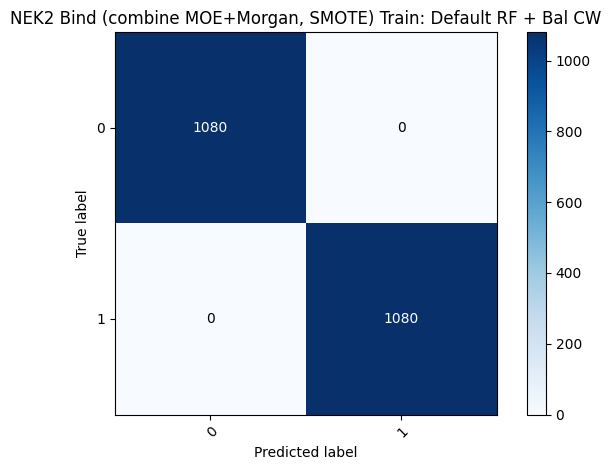

<Figure size 600x400 with 0 Axes>

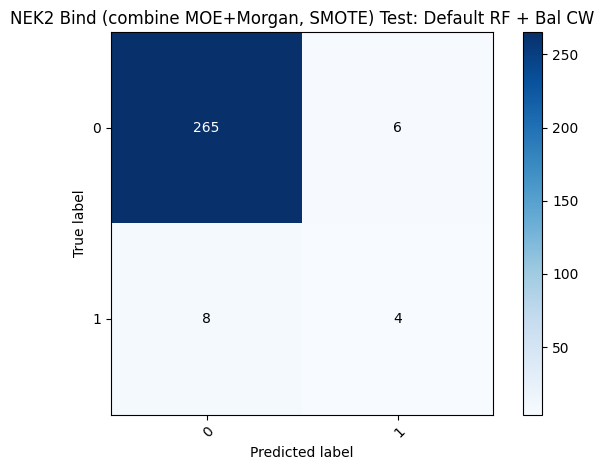

<Figure size 600x400 with 0 Axes>

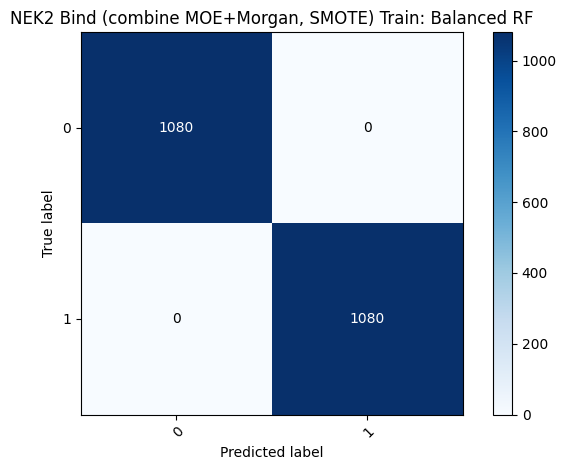

<Figure size 600x400 with 0 Axes>

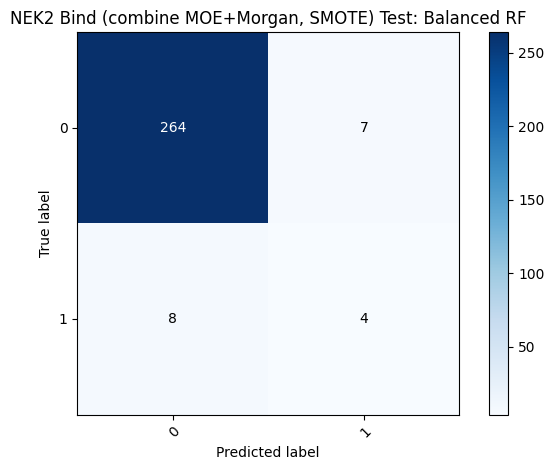

<Figure size 600x400 with 0 Axes>

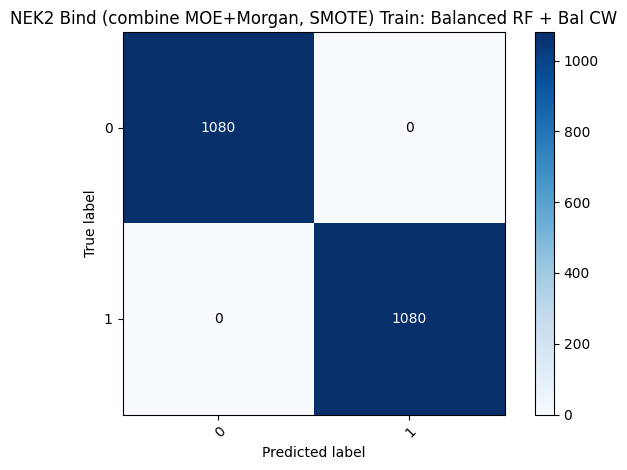

<Figure size 600x400 with 0 Axes>

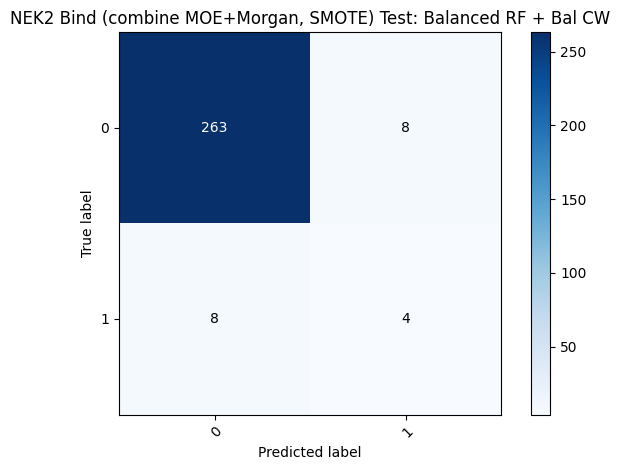

In [54]:
comboSMOTE = 'Morgan2comboSMOTE'

trainX_comboSMOTE, trainy_comboSMOTE, testX_comboSMOTE, testy_comboSMOTE = load_data(split_path, comboSMOTE, 'bind')
trainX_comboSMOTE.shape, trainy_comboSMOTE.shape, testX_comboSMOTE.shape, testy_comboSMOTE.shape
defaultcomboSMOTE, balCWcomboSMOTE, brfccomboSMOTE,brfcBCWcomboSMOTE = fit4RF(trainX_comboSMOTE, trainy_comboSMOTE,
                                            testX_comboSMOTE, testy_comboSMOTE, 'binding', 'NEK2 Bind (combine MOE+Morgan, SMOTE)')

# Combined MOE+Morgan, UNDER

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.611, precision: 0.085, recall: 0.833, sensitivity: 0.833, specificity: 0.601
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.678, precision: 0.093, recall: 0.750, sensitivity: 0.750, specificity: 0.675
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.661, precision: 0.096, recall: 0.833, sensitivity: 0.833, specificity: 0.653
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.657, precision: 0.087, recall: 0.750, sensitivity: 0.750, specificity: 0.653


<Figure size 600x400 with 0 Axes>

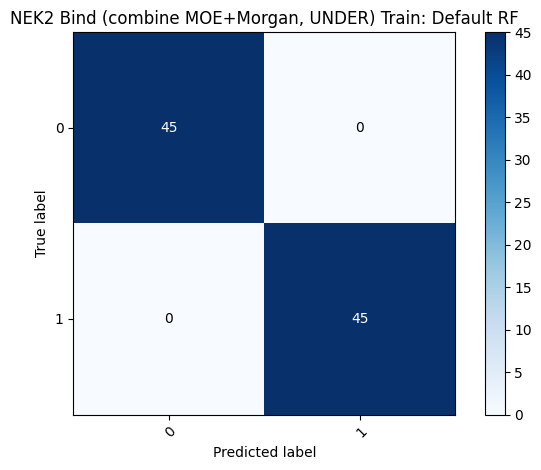

<Figure size 600x400 with 0 Axes>

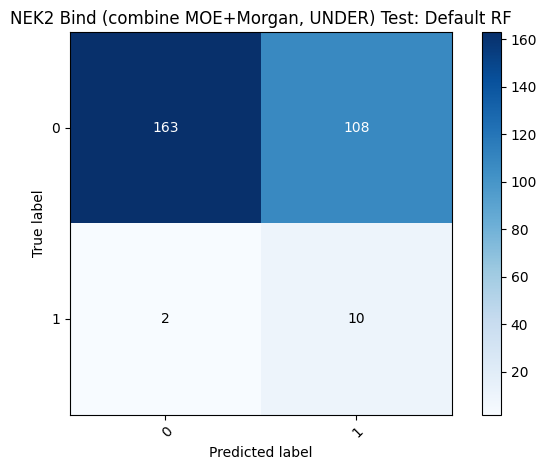

<Figure size 600x400 with 0 Axes>

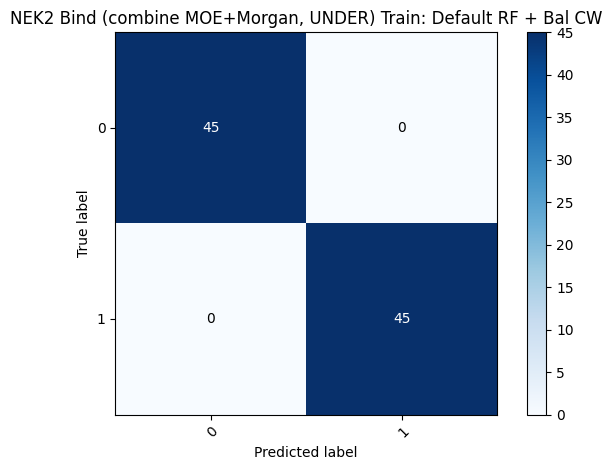

<Figure size 600x400 with 0 Axes>

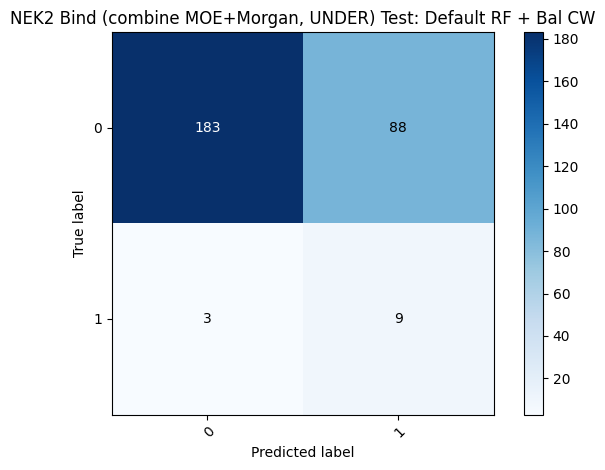

<Figure size 600x400 with 0 Axes>

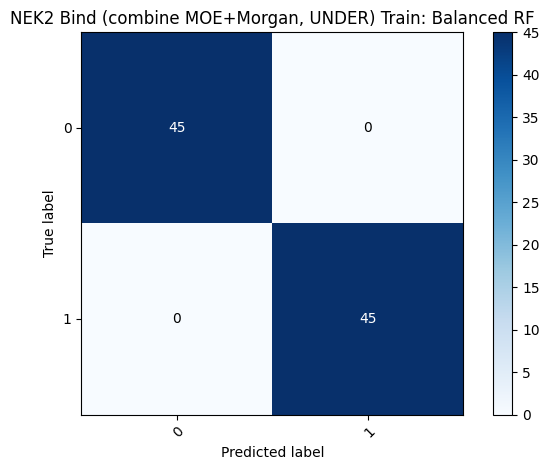

<Figure size 600x400 with 0 Axes>

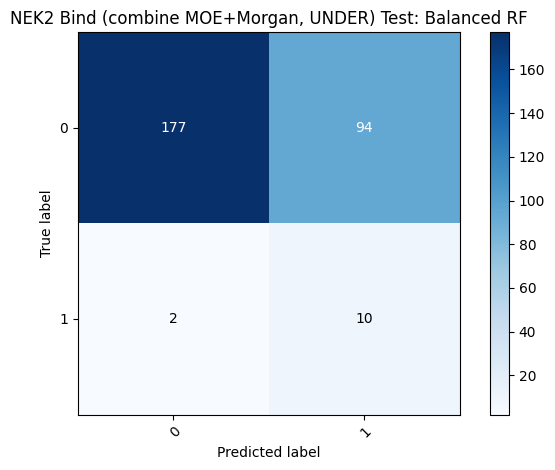

<Figure size 600x400 with 0 Axes>

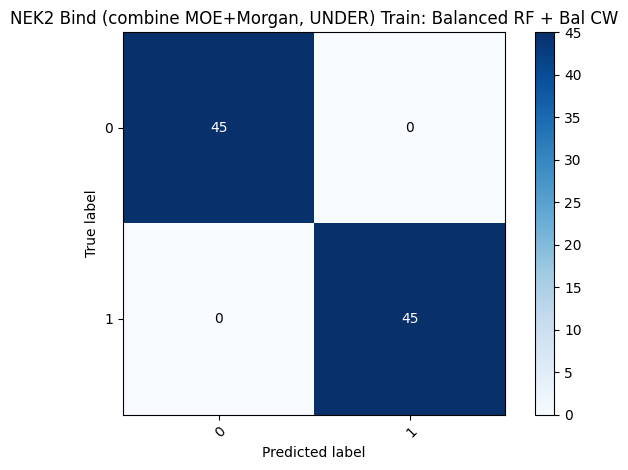

<Figure size 600x400 with 0 Axes>

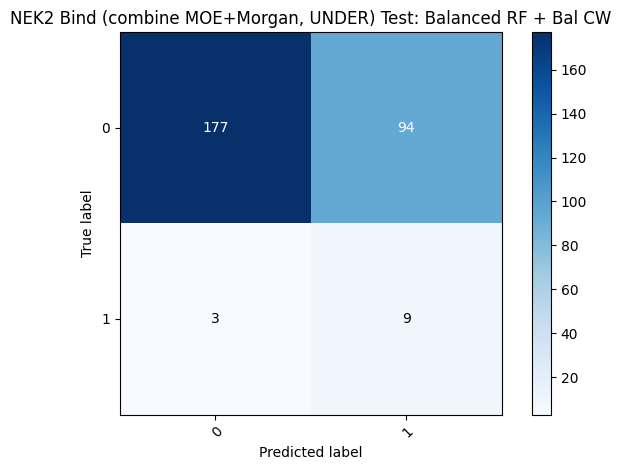

In [56]:
comboUNDER = 'Morgan2comboUNDER'

trainX_comboUNDER, trainy_comboUNDER, testX_comboUNDER, testy_comboUNDER = load_data(split_path, comboUNDER, 'bind')
trainX_comboUNDER.shape, trainy_comboUNDER.shape, testX_comboUNDER.shape, testy_comboUNDER.shape
defaultcomboUNDER, balCWcomboUNDER, brfccomboUNDER,brfcBCWcomboUNDER = fit4RF(trainX_comboUNDER, trainy_comboUNDER,
                                            testX_comboUNDER, testy_comboUNDER, 'binding', 'NEK2 Bind (combine MOE+Morgan, UNDER)')

# Combined MOE+Morgan, ADASYN

Default RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.951, precision: 0.417, recall: 0.417, sensitivity: 0.417, specificity: 0.974
Default RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.947, precision: 0.364, recall: 0.333, sensitivity: 0.333, specificity: 0.974
Balanced RF
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.951, precision: 0.417, recall: 0.417, sensitivity: 0.417, specificity: 0.974
Balanced RF + BCW
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.947, precision: 0.364, recall: 0.333, sensitivity: 0.333, specificity: 0.974


<Figure size 600x400 with 0 Axes>

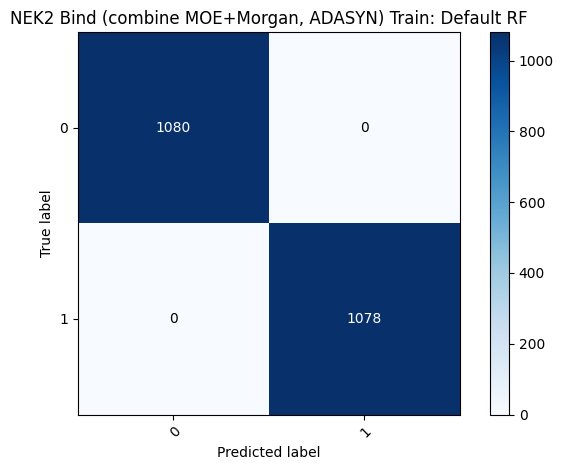

<Figure size 600x400 with 0 Axes>

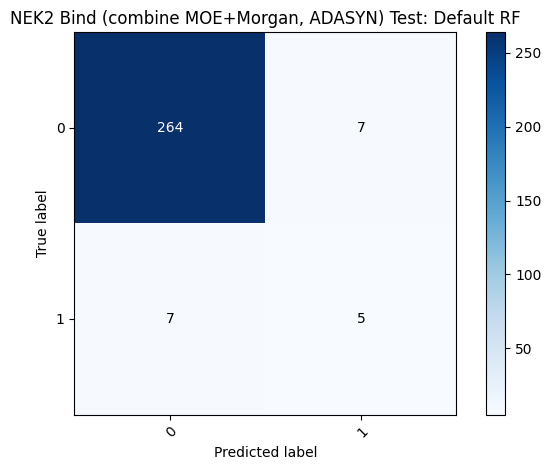

<Figure size 600x400 with 0 Axes>

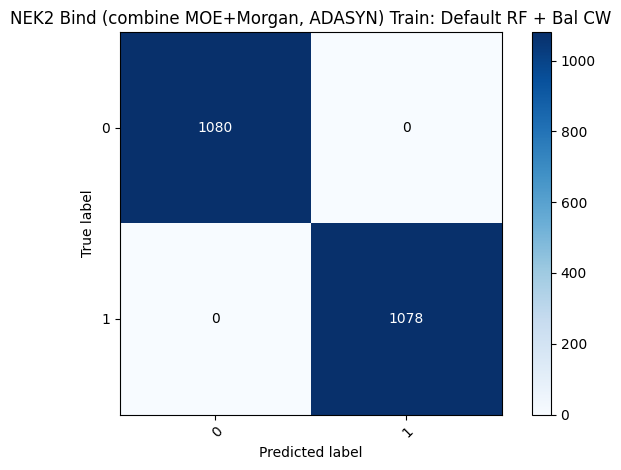

<Figure size 600x400 with 0 Axes>

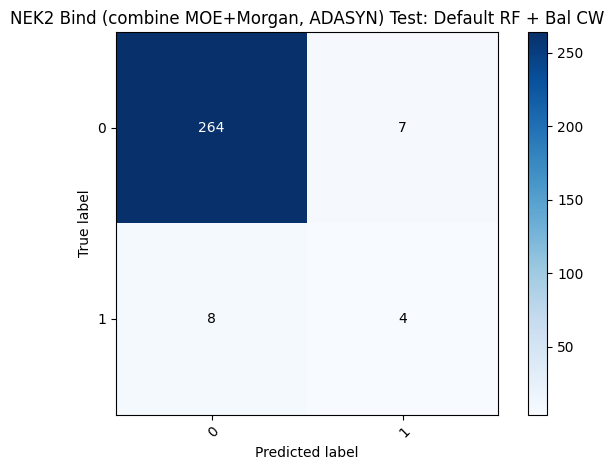

<Figure size 600x400 with 0 Axes>

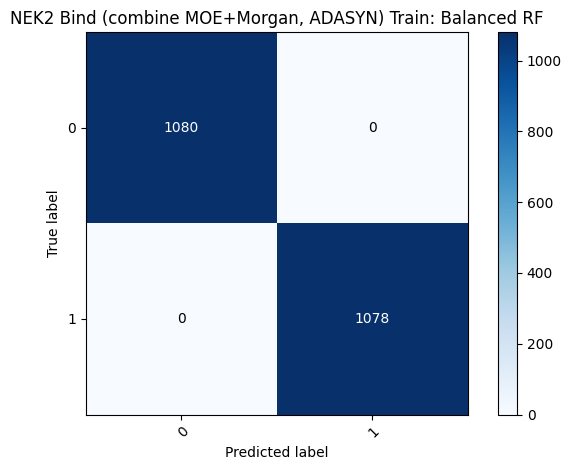

<Figure size 600x400 with 0 Axes>

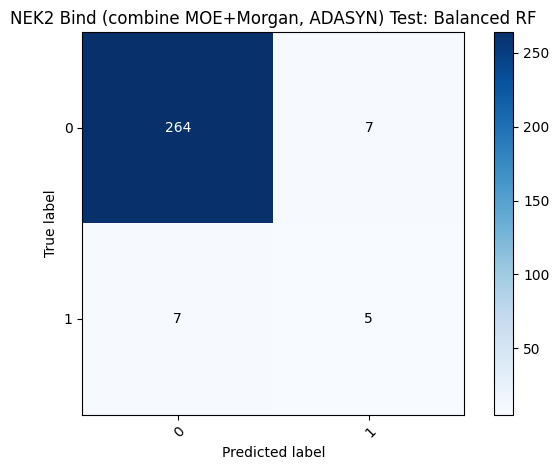

<Figure size 600x400 with 0 Axes>

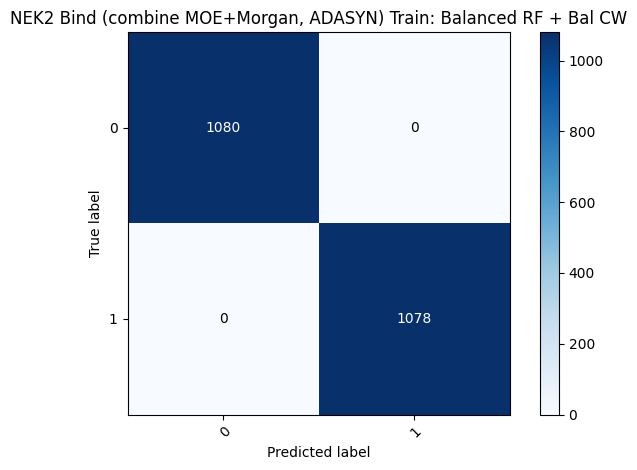

<Figure size 600x400 with 0 Axes>

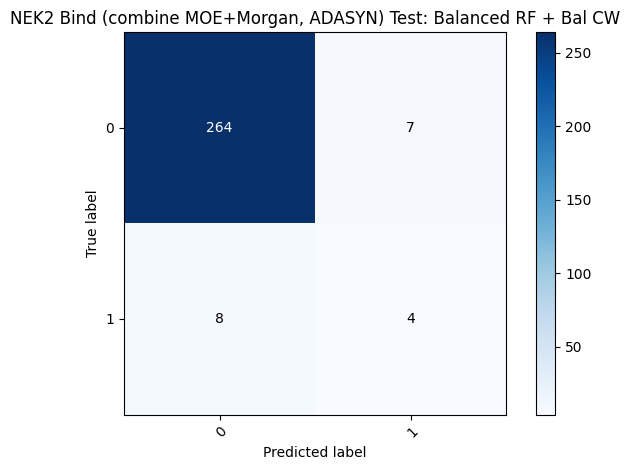

In [58]:
comboADASYN = 'Morgan2comboADASYN'

trainX_comboADASYN, trainy_comboADASYN, testX_comboADASYN, testy_comboADASYN = load_data(split_path, comboADASYN, 'bind')
trainX_comboADASYN.shape, trainy_comboADASYN.shape, testX_comboADASYN.shape, testy_comboADASYN.shape
defaultcomboADASYN, balCWcomboADASYN, brfccomboADASYN,brfcBCWcomboADASYN = fit4RF(trainX_comboADASYN, trainy_comboADASYN,
                                            testX_comboADASYN, testy_comboADASYN, 'binding', 'NEK2 Bind (combine MOE+Morgan, ADASYN)')

In [59]:
362+19+14+14

409

In [60]:
303+78+6+22

409

In [61]:
264+7+8+4 

283